#  Code for 2D staggered Lagrangian method in Cartersian coordinates

## Control equations

### Momentum equation

$$\tag{1.1}\rho \frac{d\mathbf{v}}{dt} =  -\nabla p $$ 
where $\mathbf{v}$ is the vector of velocity, and $\rho$ is the density and $p$ is the pressure.  

### Energy equation

$$ \rho \frac{dE}{dt} = -\nabla \cdot (p\mathbf{v})$$ 

where $E$ is the specific total energy and it has a realtion with the specific internal energy 
$$E = e + \frac{1}{2}\mathbf{v}\cdot\mathbf{v}$$

By (1.1) and (1.2) we have 
$$\tag{1.3} \rho \frac{de}{dt} = - p\nabla\cdot \mathbf{v}$$

In  a Cartersian coordinates $x-y$, The equations (1.1) and (1.3) can be written as
$$\rho \frac{du}{dt} = -\frac{\partial p}{\partial x},\quad \rho \frac{dv}{dt} = -\frac{\partial p}{\partial y}$$
and
$$\rho \frac{de}{dt} = -p (\frac{\partial u}{\partial x} +\frac{\partial v}{\partial y})$$

## Compatible Staggered Discretization

<img src="Grid.png" width = "800" height = "400" div align=center /> 

<img src="cellpoint.png" width = "800" height = "400" div align=center />

### Quatities:

On point: ($x_p$,$y_p$), ($u_p$,$v_p$)

Zonal:  $V_z$, $\rho_z$, $m_z$, $e_z$, $p_z$

By the relation 
$$\frac{dm_z}{dt} =0$$
we have 
$$\rho_z(t) = m_z/V_z(t)$$

Also 
$$d(x_p)/dt = u_p, \quad d(y_p)/dt = v_p$$

### Point mass 

Point mass $m_p$ is used to solve point momentum $\mu_p = m_p \bf{u}_p$ and kinetic energy $K_p = m_p \frac{\bf{u}_p^2}{2}$

<img src="Ins.jpg" width = "200" height = "400" div align=center /> 

$$m_p = \sum_{z\in Z(p)} A_z^p \rho^p_z$$

$$\rho_z(t) = m_z/V_z(t)$$

In [1]:
function MassAndDens(mz::Array{Float64,1},x::Array{Float64,1},y::Array{Float64,1})
    
    Ic, = size(mz)
    Ip, = size(Tc)
    Asbz = zeros(Float64,4)
    ρ = zeros(Float64,Ic)
    mp = zeros(Float64,Ip)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    for i in 1:Ic
        xz[1:4] = x[Tp[i,1:4]]
        yz[1:4] = y[Tp[i,1:4]]
        Asbz = A_z(xz,yz)
        Az = sum(Asbz)
        ρ[i] = mz[i]/Az
        
        for j = 1:4
            ip = Tp[i,j]
            mp[ip] = mp[ip] + Asbz[j]*ρ[i]
        end
    end
   # @show mp
    return ρ,mp
    
   
end           
        

MassAndDens (generic function with 1 method)


$$ A_z^1 = \frac{5A_{41}+5A_{12}+A_{23}+A_{34}}{12}$$
$$ A_z^2 = \frac{A_{41}+5A_{12}+5A_{23}+A_{34}}{12}$$
$$ A_z^3 = \frac{A_{41}+A_{12}+5A_{23}+5A_{34}}{12}$$
$$ A_z^4 = \frac{5A_{41}+A_{12}+A_{23}+5A_{34}}{12}$$

In [232]:
function A_z(xz::Array{Float64,1},yz::Array{Float64,1}) 
    A =zeros(Float64,4)
    xc= sum(xz[i] for i in 1:4)/4
    yc= sum(yz[i] for i in 1:4)/4
    
    A41 = Area3(xz[4],xz[1],xc,yz[4],yz[1],yc)
    A12 = Area3(xz[1],xz[2],xc,yz[1],yz[2],yc)
    A23 = Area3(xz[2],xz[3],xc,yz[2],yz[3],yc)
    A34 = Area3(xz[3],xz[4],xc,yz[3],yz[4],yc)

    A[1] = (5A41+5A12+A23+A34)/12
    A[2] = (A41+5A12+5A23+A34)/12
    A[3] = (A41+A12+5A23+5A34)/12
    A[4] = (5A41+A12+A23+5A34)/12
    
#    A[1] = (A41+A12+A23+A34)/4
#    A[2] = (A41+A12+A23+A34)/4
#    A[3] = (A41+A12+A23+A34)/4
#    A[4] = (A41+A12+A23+A34)/4
    
    
    

    return A
end

A_z (generic function with 1 method)

<img src="n1234.png" width = "300" height = "300" div align=center />

$$\overrightarrow{n}_{12} = \frac{1}{L_{12}}(y_1- y_2, x_2-x_1)  $$

$$ \mathbf{F_1}  = \frac{1}{2} ( p \cdot \overrightarrow{n}_{12}L_{12} + p\cdot \overrightarrow{n}_{41}L_{41}) $$ 

$$ \mathbf{F_1}  = \frac{1}{2}  p \left[ (y_1 - y_2, x_2 -x_1) + (y_4 -y_1, x_1 - x_4) \right] $$ 

In [307]:
function force_zone(x,y,u,v,ρ,p)
   
    Fx = zeros(Float64,4)
    Fy = zeros(Float64,4)
    
   # L12 = √((x[2]-x[1])^2+(y[2]-y[1])^2)
    n12x = -y[2]+y[1]
    n12y = x[2]-x[1]
    
  #  L41 = √((x[1]-x[4])^2+(y[1]-y[4])^2)
    n41x = -y[1]+y[4]
    n41y =  x[1]-x[4]
    
   # L23 = √((x[3]-x[2])^2+(y[3]-y[2])^2)
    n23x = -y[3]+y[2]
    n23y =  x[3]-x[2]
    
  #  L34 = √((x[4]-x[3])^2+(y[4]-y[3])^2)
    n34x = -y[4]+y[3]
    n34y =  x[4]-x[3]
    
    Fx[1] = p*(n12x+n41x)/2
    Fy[1] = p*(n12y+n41y)/2
    
    Fx[2] = p*(n12x+n23x)/2
    Fy[2] = p*(n12y+n23y)/2
    
    Fx[3] = p*(n23x+n34x)/2
    Fy[3] = p*(n23y+n34y)/2
    
    Fx[4] = p*(n34x+n41x)/2
    Fy[4] = p*(n34y+n41y)/2
    
    ex,ey = hourglass_viscosity(x, y, u, v, ρ, p) 
    
    Fx = Fx .- ex
    Fy = Fy .- ey
    
    return Fx,Fy
end           

force_zone (generic function with 1 method)

对于单元 
$$ \frac{d e}{d t} = -\frac{p}{\rho}\nabla \cdot \mathbf{u}$$ 
在单元上做积分

$$ m_z \frac{de_z}{dt} = \sum_{z\in Z(p)} \bf{F}_z^p \cdot \bf{u}_p $$  

对于节点
$$ \rho \frac{d \mathbf{u}}{dt} = - \nabla p$$

$$m_p \frac{d\bf{u}_p}{dt} = -\sum_{p\in P(z)} \bf{F}_z^p$$

$$F_z^1 = \mathbf{F}_1 - c\mathbf{e}_1$$

In [308]:
function Rhs(x::Array{Float64,1},y::Array{Float64,1},u::Array{Float64,1},v::Array{Float64,1},ρ,p::Array{Float64,1})  #Right hand e
    Ic, = size(Tp)
    Ip, = size(Tc)
    rhsu = zeros(Float64,Ip)
    rhsv = zeros(Float64,Ip) 
    rhse = zeros(Float64,Ic)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    uz = zeros(Float64,4)
    vz = zeros(Float64,4)
    
    for i in 1:Ic
        for j =1:4
            xz[j] = x[Tp[i,j]]
            yz[j] = y[Tp[i,j]]
            uz[j] = u[Tp[i,j]]
            vz[j] = v[Tp[i,j]]
        end
        Fx,Fy = force_zone(xz,yz,uz,vz,ρ[i],p[i])
      #  ex,ey = hourglass_viscosity(uz, vz, xz, yz, ρ[i], p[i])
        ∑=0
        for j in 1:4
            ip = Tp[i,j]
            ∑ = ∑ +u[ip]*Fx[j] + v[ip]*Fy[j]
        end
        rhse[i] = ∑
        
        for j = 1:4
            ip = Tp[i,j]
            rhsu[ip] +=  -Fx[j]
            rhsv[ip] +=  -Fy[j]
        end     
    end
    return rhse, rhsu,rhsv
end

Rhs (generic function with 1 method)

In [6]:
function predictor_corrector2nd(dt,u,v,x,y,p,mz,ρ,α)
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,x,y)
    e = pToe(p, ρ,problem.γ)  
    p = artificial_viscosity!(p,ρ,x,y,u,v,α)
    
    rhse, rhsu,rhsv = Rhs(x,y,u, v,ρ, p)
    
    rhsu,rhsv = Bound(rhsu,rhsv,x,y,u, v, ρ, p)
    
    x₀ =  x + dt*u
    y₀  = y + dt*v
    u₀  = u + dt*(rhsu ./ mp)
    v₀  = v + dt*(rhsv ./ mp)
    e₀  = e + dt*(rhse ./ mz)
    

    ρ,mp = MassAndDens(mz,x₀,y₀)
    p = eTop(e₀, ρ,problem.γ)   
    
    p = artificial_viscosity!(p,ρ,x₀,y₀,u₀,v₀,α) 
    rhse₀,rhsu₀,rhsv₀ = Rhs(x₀,y₀,u₀, v₀,ρ, p)
    rhsu₀,rhsv₀ = Bound(rhsu₀,rhsv₀,x₀,y₀,u₀, v₀,ρ, p)
    
    x +=  0.5dt*(u + u₀)
    y +=  0.5dt*(v + v₀)
    u +=  0.5dt*(rhsu + rhsu₀) ./ mp
    v +=  0.5dt*(rhsv + rhsv₀) ./ mp
    e +=  0.5dt*(rhse + rhse₀)  ./ mz
    
    ρ,mp = MassAndDens(mz,x,y)
    p = eTop(e, ρ,problem.γ) 
    
    return u,v,x,y,p,ρ
end

predictor_corrector2nd (generic function with 1 method)

In [295]:
function Euler1st(dt,u,v,x,y,p,mz,ρ,α)

    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,x,y)
  
     e = pToe(p, ρ,problem.γ)
     
      p = artificial_viscosity!(p,ρ,x,y,u,v,α)

     rhse, rhsu,rhsv = Rhs(x,y,u, v,ρ, p)
    
     rhsu,rhsv = Bound(rhsu,rhsv,x,y,u, v,ρ, p)
    
    x  +=  dt*u
    y  +=  dt*v
    u  += dt*(rhsu ./ mp)
    v  += dt*(rhsv ./ mp)
    e  += dt*(rhse ./ mz)
    

    ρ,mp = MassAndDens(mz,x,y)
    
    p = eTop(e, ρ,problem.γ)

    return u,v,x,y,p,ρ
end


Euler1st (generic function with 1 method)

In [67]:
function Bound(rhsu,rhsv,x,y,u,v,ρ,p)
    Ip, = size(Tc)
    Ib, = size(Tb)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    uz = zeros(Float64,4)
    vz = zeros(Float64,4)
    ip1 = zeros(Int,4)
    
    for i in 1:Ib
        ip = Tb[i,1]
    #    @show ip
        for j = 1:4
            ic = Tc[ip,j]
            if ic != 0
                ip1 = Tp[ic,1:4]
                xz[1:4] = x[ip1]
                yz[1:4] = y[ip1]
                uz[1:4] = u[ip1]
                vz[1:4] = v[ip1]
                
                if Tb[i,2] ==1
                    Fx,Fy = F_zB(xz,yz,uz,vz,ρ[ic],p[ic],j,1)
                    rhsu[ip] +=  Fx
                    rhsv[ip] += Fy 
                   # mp[ip] *= 2.0
                elseif Tb[i,2] == 2  #boundary in y
                    Fx,Fy = F_zB(xz,yz,uz,vz,ρ[ic],p[ic],j,1)
                    rhsu[ip] += Fx
                    rhsv[ip] = 0
                    v[ip] = 0
                end
                if Tb[i,3] ==1
                    Fx,Fy = F_zB(xz,yz,uz,vz,ρ[ic],p[ic],j,2)
                    rhsu[ip] += Fx
                    rhsv[ip] += Fy
                   # mp[ip] *= 2.0
                    
                elseif Tb[i,3] ==2  #boundary in x
                   Fx,Fy = F_zB(xz,yz,uz,vz,ρ[ic],p[ic],j,2)
                    rhsu[ip] += Fx
                    rhsv[ip] += Fy
                   u[ip]  = 1.0
                 end
            end
        end
    end
    return rhsu, rhsv
end  

Bound (generic function with 1 method)

### Boundary force

If one edge of a cell is a free boundary, then $f$ on the points is zero. As we have add it in RHs(), we need to remove it by resolve it again. Different from RHs(), at every point of a cell the force is composited by two parts on different edges. This is distinguished by $k$ when $k = 1$ the boundary is on y direction, forces on 12 and 34 boundary must be subtracted. When $ k =2$ the boundary is on x direction, subtract forces on 41, 23. 

In [68]:
function F_zB(x::Array{Float64,1},y::Array{Float64,1},u,v,ρ,p::Float64,j::Int,k::Int)
    Fx = 0.0
    Fy = 0.0      
    
    ex,ey = hourglass_viscosity(x, y, u, v, ρ, p)
    
    if k==1 # y direction 
     #   L12 = √((x[2]-x[1])^2+(y[2]-y[1])^2)
        n12x = -y[2]+y[1]
        n12y = x[2]-x[1]
     #   L34 = √((x[4]-x[3])^2+(y[4]-y[3])^2)
        n34x = -y[4]+y[3]
        n34y = x[4]-x[3]
        if j == 1  #Point 1
            Fx = p*n12x/2 
            Fy = p*n12y/2 - ey[1]
        elseif j == 2 
            Fx = p*n12x/2  
            Fy = p*n12y/2  - ey[2]
        elseif j == 3
            Fx = p*n34x/2 
            Fy = p*n34y/2 - ey[3]
        else 
            Fx = p*n34x/2 
            Fy = p*n34y/2 - ey[4]
        end
    elseif k == 2
      #  L41 = √((x[1]-x[4])^2+(y[1]-y[4])^2)
        n41x = -y[1]+y[4]
        n41y =  x[1]-x[4]

       # L23 = √((x[3]-x[2])^2+(y[3]-y[2])^2)
        n23x = -y[3]+y[2]
        n23y = x[3]-x[2]
        if j == 1
            Fx = p*n41x/2 - ex[1]
            Fy = p*n41y/2 
        elseif j == 2 
            Fx = p*n23x/2 - ex[2]
            Fy = p*n23y/2  
        elseif j == 3
            Fx = p*n23x/2 - ex[3]
            Fy = p*n23y/2 
        else 
            Fx = p*n41x/2 - ex[4]
            Fy = p*n41y/2  
        end
    end
    return Fx,Fy
    end           

F_zB (generic function with 1 method)

### EOS 
$$ e = \frac{p}{(\gamma-1)\rho}$$

In [9]:
function pToe(p,ρ,γ)
    return p ./ ρ/(γ-1)
end
function eTop(e,ρ,γ)
    return (γ-1)*ρ .* e
end

eTop (generic function with 1 method)

In [202]:
function CFL(SF,x::Array{Float64,1},y::Array{Float64,1},
                u::Array{Float64,1},v::Array{Float64},
                p::Array{Float64,1},ρ::Array{Float64,1})
    Ic, = size(ρ)
    cflmin = 1.e9
      cfl = 0 
    γ = problem.γ
    for i in 1:Ic
        cfl =0
        u2max = 0
        u2=0.0
        for j = 1:4
            ip = Tp[i,j]
            u2 = u[ip]^2+v[ip]^2
            if u2 > u2max ; u2max = u2; end
        end
        
        dlmin = (x[Tp[i,4]] - x[Tp[i,1]])^2+(y[Tp[i,4]]-y[Tp[i,1]])^2
       
        for j=1:3
            dl= (x[Tp[i,j+1]] - x[Tp[i,j]])^2+(y[Tp[i,j+1]]-y[Tp[i,j]])^2
            if dl < dlmin; dlmin=dl; end
        end
        c = √(γ*p[i]/ρ[i])
        cfl = √(dlmin)/(√(u2max)+c)
        if cfl < cflmin; cflmin = cfl; end
    end
 #   @show cflmin
    dt = cflmin*SF
    return dt
end 
        

CFL (generic function with 1 method)

In [191]:
function TimeSolve(u,v,x,y,p,mz,ρ,α)
    tt= problem.tt
    sf =problem.sf
    t= 0.0
    t₁ = tt/100
    t₂ = t₁
    while t<tt   
#for i in 1:1
        dt=CFL(sf,x,y,u,v,p,ρ)
        if t+dt>tt
           dt = tt-t
        end
        
        u,v,x,y,p,ρ = predictor_corrector2nd(dt,u,v,x,y,p,mz,ρ,α)
        t += dt
        if t > t₁
            println(t)
            t₁ += t₂
        end
    end
#
    return u,v,x,y,p,ρ
end

TimeSolve (generic function with 1 method)

## Artificial Viscosity 

Wilkins（1980） use the strain rate along the direction of cell acceleration to construct the artificial viscosity 
$$\frac{ds}{dt} = \frac{\partial u}{\partial x} \text{cos}^2 \alpha + \frac{\partial v}{\partial y} \text{sin}^2\alpha +(\frac{\partial u}{\partial y} + \frac{\partial v}{\partial x})\text{sin} \alpha \text{cos} \alpha$$


Then the artificial viscosity can be written as
$$ q_w = \left\{ \begin{align}
l_0^2 \rho \left( \frac{ds}{dt} \right)^2 +  l_L\rho c \left|\frac{ds}{dt}\right|, \quad \text{if}  \quad \frac{ds}{dt}< 0,\\
0, \quad \text{if} \quad \frac{ds}{dt}\ge 0. \\
\end{align}
\right.
$$
where $l_0 = a_0L$, $l_L = a_L L$, $a_0 \approx 2$, $a_L \approx 1$ and $c$ is the sonic speed.

$L$ is the reference length, and constructed as
$$L = \frac{2A}{d_1 + d_2 +d_3 +d_4} $$


<img src="L1.png" width = "400" height = "300" div align=center />

In [322]:
function artificial_viscosity_c!(p,ρ,x,y,u,v,α)
    γ = problem.γ
    xc = sum(x[i] for i in 1:4)/4
    yc = sum(y[i] for i in 1:4)/4
    
    ∂u_∂x,∂v_∂y = ∂uv(x,y,u,v)
    
  #  ds_dt = ∂u_∂x*cosd(α)^2 +∂v_∂y*sind(α)^2 + (∂u_∂y+∂v_∂x)*sind(α)*cosd(α)
    
#     L = l_viscosity(x,y,α)
#     a₀ = 2; aₗ = 1
     c = √(γ*p/ρ)
#     l₀ = a₀*L
#     lₗ = aₗ*L
    
    Lmax = max(√((x[3] - x[1])^2+(y[3] - y[1])^2) ,√((x[2] - x[4])^2+(y[2] - y[4])^2) )  
    A = area_quadrangle(x, y)
    L = A/Lmax 
    
   # if ds_dt > 0
    if ∂u_∂x + ∂v_∂y> 0
        q = 0
    else
        #q = l₀^2*ρ*(ds_dt)^2 +lₗ*ρ*c*abs(ds_dt)
        q = 0.1ρ*L*c*(abs(∂u_∂x+∂v_∂y))/A +1.0L^2*ρ*((∂u_∂x+∂v_∂y)^2)/A^2 
    end
    return p+q
end

artificial_viscosity_c! (generic function with 1 method)

$$b_2 \rho Lc \frac{\partial u}{\partial x} - b_{12}\rho L^2 \left(\frac{\partial u}{\partial x}\right)^2$$

In [287]:
function artificial_viscosity!(p,ρ,x,y,u,v,α)
    I, = size(Tp)
    
    xc = zeros(Float64,4)
    yc = zeros(Float64,4)
    uc = zeros(Float64,4)
    vc = zeros(Float64,4)
   
    for i in 1:I
        for j in 1:4
            ip = Tp[i,j]
            xc[j] = x[ip]
            yc[j] = y[ip]
            uc[j] = u[ip]
            vc[j] = v[ip]
        end
        p[i] = artificial_viscosity_c!(p[i],ρ[i],xc,yc,uc,vc,α[i])
    end
    
        return p
        
    end       

artificial_viscosity! (generic function with 1 method)

In [14]:
function l_viscosity(x,y,α)
    xc = sum(x)/4; yc = sum(y)/4
    d = zeros(Float64,4)
    for i in 1:4
    d[i] = distance(x[i],y[i],xc,yc,α)
    end
    A = A_z(x, y)
    L = 2sum(A)/sum(d)
    return L
end

l_viscosity (generic function with 1 method)

#### distance from  Point to line 
Line: $$ (xc -cos \alpha )(x-xc) = (yc-sin \alpha)(y-yc)$$
point: $x,y$

In [15]:
function distance(x,y,xc,yc,α)
    d = abs((xc - cosd(α)) * (x .-xc)- (yc-sind(α))*(y .- yc))/√((xc-cosd(α))^2+(yc-sind(α))^2)
    return d
end

distance (generic function with 1 method)

### 沙漏粘性 Hourglass

$$ \text{hg}_x = u_1 -u_2 + u_3 - u_4$$ 
$$ \text{hg}_x = v_1 -v_2 + v_3 - v_4$$ 

$$ e_{1x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{1y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{2x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{2y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{3x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{3y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{4x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{4y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

In [317]:
function hourglass_viscosity(x,y,u,v,ρ,p)
    hgx = u[1] - u[2] + u[3] -u[4]
    hgy = v[1] - v[2] + v[3] -v[4]
    
    ex =zeros(Float64,4)
    ey =zeros(Float64,4)
    A = area_quadrangle(x,y)
    c = √(problem.γ*p/ρ)
 #   @show c
    q = 0.06 # coefficient of hourglass viscosity 0.01 - 0.5 ?
    ex[1] = -0.25q*ρ*c*√(A)*hgx
    ey[1] = -0.25q*ρ*c*√(A)*hgy
    
    ex[2] = -ex[1]
    ey[2] = -ey[1]
    
    ex[3] = ex[1]
    ey[3] = ey[1]
    
    ex[4] = ex[2]
    ey[4] = ey[2]
    
 #  ex .= 0
#    ey .= 0
 #   @show ex,ey
    return ex, ey
end

hourglass_viscosity (generic function with 1 method)

In [17]:
function area_quadrangle(x::Array{Float64,1},y::Array{Float64,1}) 
   
    xc= sum(x[i] for i in 1:4)/4
    yc= sum(y[i] for i in 1:4)/4
    
    A41 = Area3(x[4],x[1],xc,y[4],y[1],yc)
    A12 = Area3(x[1],x[2],xc,y[1],y[2],yc)
    A23 = Area3(x[2],x[3],xc,y[2],y[3],yc)
    A34 = Area3(x[3],x[4],xc,y[3],y[4],yc)
    
    A = A12 + A23 +A34 +A41
    return A
end

area_quadrangle (generic function with 1 method)

In [18]:
struct prb
    tt::Float64
    sf::Float64
    γ ::Float64
end

In [19]:
function Area3(x1,x2,x3,y1,y2,y3)
    return abs((x1*y2+y1*x3+x2*y3-x1*y3-y1*x2-y2*x3)/2)
end

Area3 (generic function with 1 method)

###  $\frac{\partial (u,v)}{\partial (x,y)}$

we use the diffences between 1 and 3 points and 2 and 4 points to solve the partial differences approximately, as
$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 
Similar process to $\frac{\partial u}{\partial y}$,$\frac{\partial v}{\partial x}$ and $\frac{\partial v}{\partial y}$

In [275]:
function ∂uv(x,y,u,v)
    ∂u_∂x = 0.5(u[1]-u[3])*(y[2]-y[4]) + 0.5(u[2]-u[4])*(y[3]-y[1])
   
    ∂v_∂y = -0.5(v[1]-v[3])*(x[2]-x[4]) - 0.5(v[2]-v[4])*(x[3]-x[1])
    return ∂u_∂x,∂v_∂y
end

∂uv (generic function with 1 method)

In [173]:
using DelimitedFiles
function Output(Ix,Iy,x,y,u,v,p,ρ,mz)

    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
    A = zeros(Float64,Ip,7)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"mz\" ZONE T=\"Zone 1\" 
I=$Ix,J=$Iy,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)

    for i in 1:Ip
        nc = 0
        ρz = 0.0
        pz = 0.0
        m = 0.0
        for j = 1:4
            ic = Tc[i,j] 
            if ic != 0
                ρz += ρ[ic]
                pz += p[ic]
                m += mz[ic]
                nc +=  1
            end
        end
        ρz = ρz/nc
        pz = pz/nc
        m = m /nc
        A[i,1] = x[i]
        A[i,2] = y[i]
        A[i,3] = u[i]
        A[i,4] = v[i]
        A[i,5] = ρz
        A[i,6] = pz
        A[i,7] = m
        
    end
    writedlm(io, A, "  ")
    close(io)
end

Output (generic function with 1 method)

In [174]:

function Output_cell(Ix,Iy,x,y,u,v,p,ρ,mz)

    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
   
    A = zeros(Float64,Ip,7)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"mz\" ZONE T=\"Zone 1\" 
I=$Ix,J=$Iy,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)

    for i in 1:Ic
        xc = 0
        yc =0
        uc =0
        vc =0
        for j = 1:4
            ip = Tp[i,j] 
                xc += x[ip]/4
                yc += y[ip]/4
                uc += u[ip]/4
                vc += v[ip]/4
        
        end
        
        A[i,1] = xc
        A[i,2] = yc
        A[i,3] = uc
        A[i,4] = vc
        A[i,5] = ρ[i]
        A[i,6] = p[i]
        A[i,7] = mz[i]
        
    end
      writedlm(io, A, "  ")
    close(io)
end

Output_cell (generic function with 1 method)

In [168]:
using DelimitedFiles

In [22]:
using DelimitedFiles
function Output1(x,y,rhs)

    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data1.dat", "w+")
    A = zeros(Float64,Ip,3)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"p\"  ZONE T=\"Zone 1\" 
I=400,J=40,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)

    for i in 1:Ic
        nc = 0
        ρz = 0.0
        pz = 0.0
        ip  = Tp[i,1]
        A[i,1] = x[ip]
        A[i,2] = y[ip]
        A[i,3] = rhs[i]
        
    end
    writedlm(io, A, "  ")
    close(io)
end

Output1 (generic function with 1 method)

In [23]:
using DelimitedFiles
function Output2(x,y,rhs)

    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data1.dat", "w+")
    A = zeros(Float64,Ip,3)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"p\"  ZONE T=\"Zone 1\" 
I=401,J=41,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)

    for i in 1:Ip
        nc = 0
        ρz = 0.0
        pz = 0.0
       # ip  = Tp[i,1]
        A[i,1] = x[i]
        A[i,2] = y[i]
        A[i,3] = rhs[i]
        
    end
    writedlm(io, A, "  ")
    close(io)
end

Output2 (generic function with 1 method)

In [24]:
function outputline(Ix,Iy,x,y,u,v,ρ,p,mz)
    I, = size(ρ)
    
    uL =  zeros(Float64,Ix)
    xL =  zeros(Float64,Ix)
    vL =  zeros(Float64,Ix)
    ρL =  zeros(Float64,Ix)        
    pL =  zeros(Float64,Ix)  
            
    for i in 1:Ix
        j = Int8(floor(Iy/2))
            ip = i+(j-1 ) *(Ix+1)
            ic =i+(j-1)*Ix
            uL[i] = u[ip]
            xL[i]  = x[ip]
            vL[i] = v[ip]
            ρL[i]  = ρ[ic]
            pL[i] = p[ic]
    end
    return xL,uL,vL,ρL,pL
end

outputline (generic function with 1 method)

### noh 算例 

In [26]:
@inline function InitTest1()

    global problem = prb(0.1,0.3,1.4)
     
    I = 200
    J = 20
    dx = 1.0/I
    dy = 0.1/J
    
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ip =i+(j-1)*(I+1) 
                Tb[ib,1] = ip
                if i==1 
                   Tb[ib,3] = 1
                    Tc[ip,2] =0
                    Tc[ip,3] =0
                end   
                 if  i==I+1 
                    Tb[ib,3] = 1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tc[ip,1] =0
                    Tc[ip,4] =0
                end
            
                if j==1 
                    Tb[ib,2] = 1
                    Tc[ip,3] = 0
                    Tc[ip,4] = 0
                end
                if j==J+1
                    Tb[ib,2] = 1
                    Tc[ip,1] = 0
                    Tc[ip,2] = 0
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    α = zeros(Float64,Ic)
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = i*dx
            y[ip] = j*dy
            
            u[ip] = 1.0
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i<=100
                mz[ic] = (2+sin(2π*dx*i)) * Az[ic]
                p[ic] = 1.0
                ρ[ic] = sin(2π*dx*i)+2
#             else
#                 mz[ic] = 0.1 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 0.1
#             end
        end
    end
    
    return x,y,u,v,mz,p,ρ,Az,α
end

###  1D sod 算例

In [27]:
@inline function InitTest2()

    global problem = prb(0.1,0.3,1.4)
     
    I = 200
    J = 10
    dx = 1.0/I
    dy = 0.1/J
    
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ip =i+(j-1)*(I+1) 
                Tb[ib,1] = ip
                if i==1 
                   Tb[ib,3] = 1
                    Tc[ip,2] =0
                    Tc[ip,3] =0
                end   
                 if  i==I+1 
                    Tb[ib,3] = 1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tc[ip,1] =0
                    Tc[ip,4] =0
                end
            
                if j==1 
                    Tb[ib,2] = 1
                    Tc[ip,3] = 0
                    Tc[ip,4] = 0
                end
                if j==J+1
                    Tb[ib,2] = 1
                    Tc[ip,1] = 0
                    Tc[ip,2] = 0
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    α = zeros(Float64,Ic)
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = i*dx
            y[ip] = j*dy
            if i >=I/2
                u[ip] = 0.
            else
                u[ip] = 0
            end
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
            if i>=I/2
                mz[ic] = 0.125 * Az[ic]
                p[ic] = 0.1
                ρ[ic] = 0.125
            else
                mz[ic] = 1.0 * Az[ic]
                p[ic] = 1.0
                ρ[ic] = 1.0
            end
        end
    end
    
    return x,y,u,v,mz,p,ρ,Az,α,I,J
end

In [ ]:
x,y,u,v,mz,p,ρ,Az,α,I,J=InitTest2()
#Output1
u,v,x,y,p,ρ = TimeSolve(u, v, x, y, p, mz,ρ,α)
Output(I+1, J+1,x,y, u, v, p, ρ, mz)

In [ ]:
Output(I+1, J+1, u, v, p, ρ, mz)

In [ ]:
### 输出线
xL,uL,vL,ρL,pL = outputline(200, 10, x, y, u, v, ρ, p, mz)

####  精确解

In [ ]:
using ExactRiemannEuler

In [ ]:
push!(LOAD_PATH, "/home/bfly/workspace/computeforcfd/Lag2D/")

In [ ]:
Wₗ = ExactRiemannEuler.W(1.0,0.0,1.0)
Wᵣ = ExactRiemannEuler.W(0.125,0.0,0.1)
γ = 1.4
x1,U = SolveDistr(0.13,Wₗ,Wᵣ,γ)

In [ ]:
using Plots
plot!(xL,ρL)
#plot!(x1 .+0.5,U[:,1])

In [ ]:
Output(x, y, u, v, p, ρ, mz)

In [ ]:
floor(0.3)

##  Salzman 算例

$$ x(i,j) = (i-1)\Delta x +(11 - j) \text{sin}(0.01\pi (i-1))\Delta y, \quad y(i,j) = (j-1) \Delta y$$

<img src="mesh.png" width = "1000" height = "300" div align=center />

初始条件：

  $$ (\rho, u, p,e) = \left\{ \begin{aligned}
  (4.0,1.11,0.987,0.617) \quad  i < 5 \\
  (0.6667,0,2.667\times 10 ^{-5},1.0\times 10^{-4}) \quad i \ge 5\\
  \end{aligned}
  \right.$$ 

## 激波关系式


$$\rho_R(u_R - s)  = \rho_L(u_L -s) $$
$$\rho_R u_R(u_R -s) = \rho_Lu_L(u_L -s) + p_L -p_R$$
$$ \rho_RE_R(u_R -s) = \rho_LE_L(u_L -s) + p_Lu_L - u_Rp_R $$

$$e = \frac{p}{(\gamma -1)\rho} $$

In [237]:
using SymPy
@vars ρₗ ρᵣ pₗ pᵣ s eₗ eᵣ  uᵣ uₗ r 
exp1 = solve([ρᵣ*(uᵣ-s)-ρₗ*(uₗ-s),
       ρᵣ*uᵣ*(uᵣ-s)-ρₗ*uₗ*(uₗ-s)+pᵣ-pₗ,
       ρᵣ*(eᵣ+uᵣ^2/2)*(uᵣ-s)-ρₗ*(eₗ+uₗ^2/2)*(uₗ-s)-pₗ*uₗ+pᵣ*uᵣ,
        eₗ-pₗ/(r-1)/ρₗ,
        eᵣ-pᵣ/(r-1)/ρᵣ],[ρₗ,pₗ,pᵣ,uₗ,eₗ])

2-element Array{NTuple{5,Sym},1}:
 (ρᵣ, eᵣ*ρᵣ*(r - 1), eᵣ*ρᵣ*(r - 1), uᵣ, eᵣ)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
 (ρᵣ*(r + 1)*(s - uᵣ)^2/((r - 1)*(2*eᵣ*r + s^2 - 2*s*uᵣ + uᵣ^2)), -ρᵣ*(eᵣ*r^2 - 2*eᵣ*r + eᵣ - 2*s^2 + 4*s*uᵣ - 2*uᵣ^2)/(r + 1), eᵣ*ρᵣ*(r - 1), (-2*eᵣ*r^2 + 2*eᵣ*r + r*s*uᵣ - r*uᵣ^2 + 2*s^2 - 3*s*uᵣ + uᵣ^2)/((r + 1)*(s - uᵣ)), (-2*eᵣ^2*r^3 + 4*eᵣ^2*r^2 - 2*eᵣ^2*r - eᵣ*r^2*s^2 + 2*eᵣ*r^2*s*uᵣ - eᵣ*r^2*uᵣ^2 + 6*eᵣ*r*s^2 - 12*eᵣ*r*s*uᵣ + 6*eᵣ*r*uᵣ^2 - eᵣ*s^2 + 2*eᵣ*s*uᵣ - eᵣ*uᵣ^2 + 2*s^4 - 8*s^3*uᵣ + 12*s^2*uᵣ^2 - 8*s*uᵣ^3 + 2*uᵣ^4)/(r^2*s^2 - 

In [318]:
ρₗ = exp1[2][1](ρᵣ=>1,uᵣ=>0, s=>1.3333, eᵣ=> 1.e-4, r=>5/3)
pₗ = exp1[2][2](ρᵣ=>1,uᵣ=>0, s=>1.3333, eᵣ=> 1.e-4, r=>5/3)
pᵣ = exp1[2][3](ρᵣ=>1,uᵣ=>0, s=>1.3333, eᵣ=> 1.e-4, r=>5/3)
uₗ = exp1[2][4](ρᵣ=>1,uᵣ=>0, s=>1.3333, eᵣ=> 1.e-4, r=>5/3)
eₗ = exp1[2][5](ρᵣ=>1,uᵣ=>0, s=>1.3333, eᵣ=> 1.e-4, r=>5/3)

@show ρₗ,pₗ,pᵣ,uₗ,eₗ

(ρₗ, pₗ, pᵣ, uₗ, eₗ) = (3.99925010311129, 1.33325000083333, 6.66666666666667e-5, 0.999912498437461, 0.500062499140566)


(3.99925010311129, 1.33325000083333, 6.66666666666667e-5, 0.999912498437461, 0.500062499140566)

In [332]:
function init_salzmann()
    tt = 0.6
    
    cfl = 0.3
    γ = 5/3
    
    global problem = prb(tt,cfl,γ)
     
    I = 104
    J = 10
    dx = 1.04/I
    dy = 0.1/J
    
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ip =i+(j-1)*(I+1) 
                Tb[ib,1] = ip
                if i==1 
                   Tb[ib,3] = 2
                    Tc[ip,2] =0
                    Tc[ip,3] =0
                end   
                 if  i==I+1 
                    Tb[ib,3] = 1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tc[ip,1] =0
                    Tc[ip,4] =0
                end
            
                if j==1 
                    Tb[ib,2] = 2
                    Tc[ip,3] = 0
                    Tc[ip,4] = 0
                end
                if j==J+1
                    Tb[ib,2] = 2
                    Tc[ip,1] = 0
                    Tc[ip,2] = 0
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    α = zeros(Float64,Ic)
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
             if i< 5
                x[ip] = (i-1)*dx
                y[ip] =(j-1)*dy
             else
                 x[ip] = (i-1)*dx +(11-j)*sin(0.01π*(i-5))*dy
                 y[ip] = (j-1)*dy
             end
            if i <2
                u[ip] = 1.0
            else
                u[ip] = 0
            end
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
#             if i<2
#                  p[ic] = 1.333
#                 ρ[ic] = 4.0
#                 mz[ic] = ρ[ic] * Az[ic]
               
#             else
                p[ic] = 6.6667e-5
                ρ[ic] = 1.0
                mz[ic] = ρ[ic] * Az[ic]
#             end
        end
    end
    
    return x,y,u,v,mz,p,ρ,Az,α,I,J
end

init_salzmann (generic function with 1 method)

In [ ]:
x,y,u,v,mz,p,ρ,Az,α,I,J = init_salzmann()
u,v,x,y,p,ρ = TimeSolve(u, v, x, y, p, mz, ρ, α)
Output(I+1, J+1, x, y, u, v, p, ρ, mz)

0.006649131183440158
0.012111142973976178
0.01830801955319146
0.02415362177301158
0.030338179637676644
0.03622039360116987
0.04214492478339063
0.04839388838945566
0.05434477019514795
0.06036449712506217
0.06605702484322093
0.0720457973927761
0.07805414052636618
0.0843100802479498
0.0900219728384598
0.09635551351478323
0.10223420907634172
0.1080225271429869
0.11424451123704676
0.12004045468235229
0.12620052177047583
0.13220195984030772
0.13816239444536607
0.14417723889265532
0.1501090071982135
0.15629924083223368
0.1620738720175588
0.16805741732010787
0.17402970228682182
0.18003139512314453
0.18601939534198944
0.19205639807408792
0.19805002561494664
0.20401538595711685
0.21007588320679427


In [175]:
function cell_coordinate(x,y)
    Ip, = size(Tc)
    Ic, = size(Tp)
    xc = zeros(Float64,Ic)
    yc = zeros(Float64,Ic)
    
    for i in 1:Ic
        for j = 1:4
            ip = Tp[i,j] 
            xc[i] += x[ip]/4
            yc[i] += y[ip]/4
        end
        
    end
    
    return xc,yc
end

cell_coordinate (generic function with 1 method)

x

In [142]:
mz

1040-element Array{Float64,1}:
 0.0004              
 6.667000000000004e-5
 6.667e-5            
 6.667000000000002e-5
 8.656447542351877e-5
 8.654484197816479e-5
 8.650559446329738e-5
 8.644677161147471e-5
 8.636843147375016e-5
 8.627065136238174e-5
 8.615352777453367e-5
 8.601717629704679e-5
 8.586173149236838e-5
 ⋮                   
 6.569039660762992e-5
 6.567925293613092e-5
 6.566908701235079e-5
 6.565990886884503e-5
 6.565172756331218e-5
 6.564455116974402e-5
 6.563838677039918e-5
 6.563324044875279e-5
 6.562911728360749e-5
 6.562602134402306e-5
 6.562395568536578e-5
 6.562292234612553e-5

### chenjuan shuqiwang 

In [159]:
using Plots

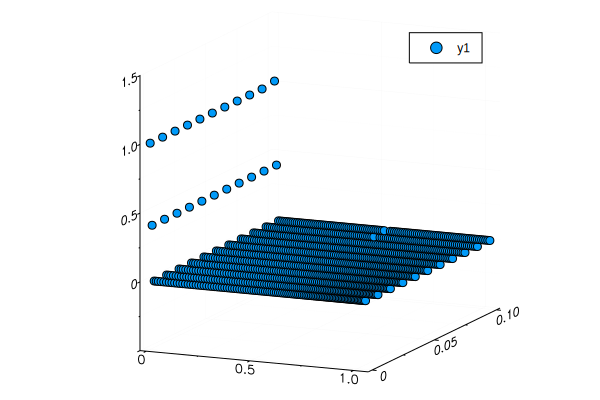

In [164]:
scatter3d(x,y,u)

In [ ]:
- 0.9/0.55*400

In [ ]:
write(stdout, "Hello World"); 

In [ ]:
x = zeros(UInt8, 4)

In [ ]:
read!(stdin, x) 